In [43]:
import numpy as np
import xarray as xr
import os
import sys
sys.path.append("../")
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from src.data_utils import *        
from src.models import DeepONet
from src.pinn_train_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
batch_size = 64
chl_data = torch.load(data_dir + "chl_dataset_2016_2022.pt")
train_loader, test_loader = get_data_loaders(chl_data, 0.8, batch_size=batch_size)

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
def get_water_mask(zarr_ds):
    st_ = zarr_ds["sst"].values[0, :, :]
    water_mask = np.zeros_like(st_)
    water_mask[np.isnan(st_)] = 1.0
    return torch.tensor(water_mask)


water_mask = get_water_mask(zarr_ds)

In [7]:
def init_network(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.1)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

In [10]:
from src.models import DeepONet

torch.random.manual_seed(0)
model = DeepONet(
    9,
    2,
    64,
    50,
    (176, 240),
    branch_linear_act=nn.SiLU,
    onet_output_fun=F.sigmoid,
    trunk_act=nn.ELU,
).to(device)
# model.apply(init_network)
opt = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()
scheduler = ReduceLROnPlateau(
    opt, mode="min", factor=0.5, threshold=2e-4, patience=10, verbose=True
)
lambda_phys = 0.05
D = 1e-4

/gscratch/rao/aresf/miniconda3/envs/torch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 50/150, Train Loss: 0.0022, Val Loss: 0.0022, Val phys. Loss: 0.0029


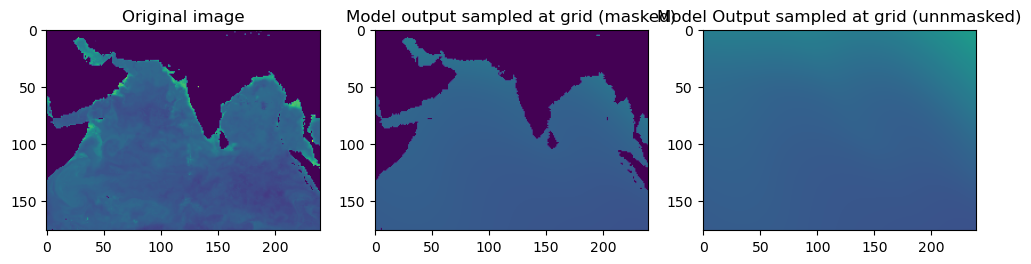

KeyboardInterrupt: 

In [11]:
torch.cuda.empty_cache()
num_sensors = 1500
n_epochs = 150
train_losses, test_losses = train(
    model,
    opt,
    criterion,
    train_loader,
    test_loader,
    device,
    water_mask,
    sample_water_only=True,
    num_epochs=n_epochs,
    lambda_physics=lambda_phys,
    scheduler=scheduler,
    num_sensors=num_sensors,
    show_every=50,
    plot_every=True,
)

In [13]:
def sample_grid(model, x):
    torch.cuda.empty_cache()
    batch_size = x.shape[0]
    height, width = (176, 240)
    dev = x.device
    grid_coords = get_grid_coords(batch_size, height, width).to(dev)

    output = torch.zeros((batch_size, height, width)).to(dev)
    chunk_size = 2000  # Adjust based on your GPU memory
    for i in range(0, height * width, chunk_size):
        chunk_coords = grid_coords[:, i : i + chunk_size, :]
        with torch.no_grad():
            chunk_output = model(x, chunk_coords)
        output.view(batch_size, -1)[:, i : i + chunk_size] = chunk_output
    torch.cuda.empty_cache()
    return output.cpu().numpy()


def plot_grid_output(
    output, x, y, water_mask, batch_ind=2, savefig=False, savename=None
):
    wm = (1.0 - water_mask).repeat(batch_size, 1, 1)
    masked_output = wm * output
    fig, axs = plt.subplots(1, 3, figsize=(12, 10))
    axs[0].imshow(y.cpu()[batch_ind, :, :], clim=(0, 1))
    axs[0].set_title("Original image")
    axs[1].imshow(masked_output[batch_ind, :, :], clim=(0, 1))
    axs[1].set_title("Model output sampled at grid (masked)")
    axs[2].imshow(output[batch_ind, :, :], clim=(0, 1))
    axs[2].set_title("Model Output sampled at grid (unnmasked)")

    if savefig:
        plt.savefig(f"../plots/{savename}.png")

    plt.show()

In [14]:
x, y = next(iter(train_loader))
x = x.to(device)
output = sample_grid(model, x)

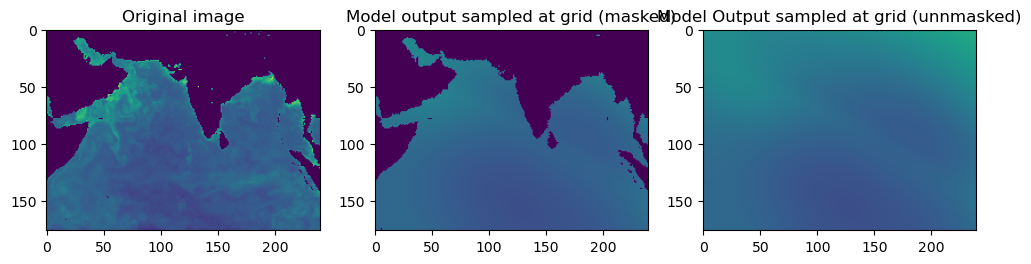

In [22]:
plot_grid_output(output, x, y, water_mask, batch_ind=0)

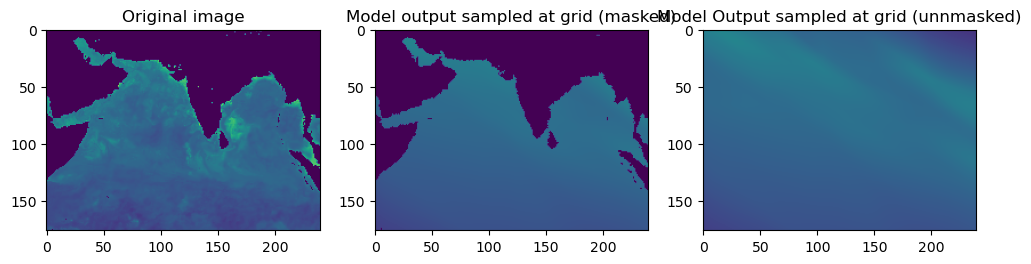

In [22]:
plot_grid_output(
    output, x, y, water_mask, batch_ind=10, savefig=False, savename=f"DONet_v0_D_{D}"
)

In [21]:
def plot_grid_output(
    model, x, y, water_mask, batch_ind=2, savefig=False, savename=None
):
    wm = (1.0 - water_mask).repeat(batch_size, 1, 1)
    output = sample_grid(model, x)
    masked_output = wm * output
    fig, axs = plt.subplots(1, 3, figsize=(12, 10))
    axs[0].imshow(y.cpu()[batch_ind, :, :], clim=(0, 1))
    axs[0].set_title("Original image")
    axs[1].imshow(masked_output[batch_ind, :, :], clim=(0, 1))
    axs[1].set_title("Model output sampled at grid (masked)")
    axs[2].imshow(output[batch_ind, :, :], clim=(0, 1))
    axs[2].set_title("Model Output sampled at grid (unnmasked)")

    if savefig:
        plt.savefig(f"../plots/{savename}.png")

    plt.show()